# A Hitchhiker's Guide to Indian Patent Analytics

This notebook is intended to be read with the article of the same title [published on LinkedIn](https://www.linkedin.com/pulse/draft/AgGvJ9CZkdm63AAAAWZmrUzA6jtaXXUHIq2OjKruZEKaxFrRZp1Adc-nunE7H5pnVU8DakU).

### Preliminaries

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Load Excel File Downloaded from Patentscope

In [2]:
df = pd.read_excel('resultList2.xls', 'ResultSet')
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

print('Data has %d rows and %d columns' % df.shape)
print('Column names: %s' % ', '.join(df.columns))

Data has 592 rows and 11 columns
Column names: application_id, application_number, publication_number, publication_date, title, priority_data, ipc, applicants, inventors, fp_image, nat_phase_entries


# Preliminary Data Analysis and Enrichment

### Add a *company* column

In [3]:
df['company'] = np.where(df['applicants'].str.contains('TATA STEEL'), 
    'TATA', 'SAIL')

### Calculate and Display Relative Patent Counts

TATA    374
SAIL    218
Name: company, dtype: int64



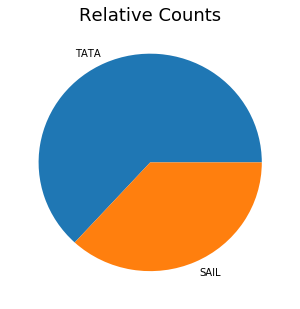

In [4]:
counts = df['company'].value_counts()

print(counts)
print('')

ax = counts.plot.pie(figsize=(5, 5))
ax.set_title('Relative Counts', fontsize=18)
ax.set_ylabel('')
None

### Display Some Sample Data

In [5]:
df[['publication_number', 'publication_date', 'title', 'ipc', 'company', 'inventors']].sample(5)

,publication_number,publication_date,title,ipc,company,inventors
482,IN218/KOL/2015,20.10.2017,METHOD FOR CONTROLLING THE TOE RADIUS OF RAILR...,B63B 17/00,SAIL,JHA SAMIR KUMAR;PRAKASH KUNDAN;THAKUR PURENDRA...
338,IN201631040349,01.06.2018,LOW-Ni AUSTENITIC STAINLESS STEEL WITH SUPERIO...,C22C 38/00;C21D 8/00;C21D 7/00,SAIL,"PANDURANGAN, Saravanan;PANDURANGAN, Saravanan;..."
24,IN43/KOL/2013,18.07.2014,A REAL- TIME PROCESS TO OPTIMIZE THE BLAST FUR...,C21B /,TATA,DEBJANI SAMBASIVAM;ARYA KUMAR BHATTACHARYA;ABH...
295,IN201631036879,04.05.2018,AN APPARATUS FOR ONLINE MEASUREMENT OF LIQUID ...,B22D 11/00,TATA,Abhishek Chakraborty;Raghavendra Krishnamurth...
211,IN201631009827,10.11.2017,METHOD FOR CONCENTRATING THE VITRINITE GROUP M...,C10C 1/00,TATA,VIMAL KUMAR CHANDALIYA;RASHMI SINGH;PINAKPANI ...


# *Feature Engineering* -- Convert IPC codes into Text (*Sentences*)

Convert the IPC codes into *sentences* to facilitate subsequent processing with scikit-learn's [text-feature-extraction](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) capabilities.

### Extract IPC codes into arrays

In [6]:
ipc_regex = re.compile('[A-H]\s*[0-9]{2}\s*[A-Z]\s*(?:[0-9]+(?:/(?:[0-9]+)?)?)?')

df['ipc_list'] = df['ipc'].str.findall(ipc_regex)
df = df[df['ipc_list'].str.len() != 0]

print('Count of records with IPCs: %d' % len(df))
ipclen = df['ipc_list'].str.len()
print('IPC nbr: min=%d, mean=%f, max=%d' % (ipclen.min(), ipclen.mean(), ipclen.max()))

Count of records with IPCs: 588
IPC nbr: min=1, mean=1.406463, max=4


### IPC to Sentence Converter

In [7]:
ipc_pattern = '([A-H])\s*(?:(\d{2})\s*(?:([A-Z])\s*(?:(\d+)\s*(?:/\s*(\d+))?)?)?)?'
ipcregex = re.compile(ipc_pattern)

def ipc_sentence(ipc):
    parts = [part.strip('[ /]') for part in re.match(ipcregex, ipc).groups() if part]
    s = parts[0]
    if len(parts) > 1:
        s += ' ' + parts[0] + parts[1]
        if len(parts) > 2:
            s += ' ' + parts[0] + parts[1] + parts[2]
            if len(parts) > 3:
                s += ' ' + parts[0] + parts[1] + parts[2] + parts[3]
                if len(parts) > 4:
                    s += ' ' + parts[0] + parts[1] + parts[2] + parts[3] + parts[4]
    return s

def multi_ipc_sentence(ipcs):
    return ' '.join([ipc_sentence(ipc) for ipc in ipcs])

### Test IPC to Sentence Conversion

In [8]:
multi_ipc_sentence(['A 13 K 127 / 999'])

'A A13 A13K A13K127 A13K127999'

### Convert all IPC Codes

### Display Converted Sentence Samples

In [9]:
ipc_sentence = df['ipc_list'].map(multi_ipc_sentence)
ipc_sentence.sample(10)

54     C C22 C22C C22C38 C22C3804 C C22 C22C C22C38 C...
161    C C21 C21D C21D8 C21D812 H H01 H01F H01F1 H01F...
260                             H H02 H02K H02K1 H02K127
477                             F F21 F21S F21S8 F21S810
114                                           C C23 C23C
120                            B B03 B03D B03D1 B03D1016
491                           C C10 C10B C10B39 C10B3916
108                             B B03 B03B B03B9 B03B900
212                             C C21 C21D C21D9 C21D946
302    G G01 G01R G01R31 G01R3100 G G01 G01N G01N3 G0...
Name: ipc_list, dtype: object

# Apply Text-Processing Techniques

### Generate TF-IDF Word Counts

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(use_idf=True, stop_words='english').fit(ipc_sentence)
tf = vectorizer.transform(ipc_sentence)
print('Rows: %d, Features: %d' % tf.shape)

Rows: 588, Features: 984


# Prepare Word Counts for Scatter Plot Display

### Use TruncatedSVD to Reduce to 50 Features

In [11]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components=50)
tsvd100 = tsvd.fit_transform(tf)
print('Rows: %d, Features: %d' % tsvd100.shape)

Rows: 588, Features: 50


### Use t-SNE to Obtain 2-D (X, Y) Mapping

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(tsvd100)
print('Rows: %d, Features: %d' % tsne.shape)

Rows: 588, Features: 2


In [13]:
tsne[:10, :]

array([[-32.64204407,   2.55527902],
       [  0.77148104,   2.51399899],
       [  2.88212943,  21.16969109],
       [ 11.57896805, -24.23793221],
       [ 11.18965912,  -4.30511665],
       [  6.19977379, -18.84681129],
       [-11.47440243,  21.99637413],
       [ -9.03295135,  23.0854187 ],
       [-21.87161064,  -9.34305668],
       [ 18.89047432,   8.46304512]], dtype=float32)

### Scatter Plot of 2-D Data

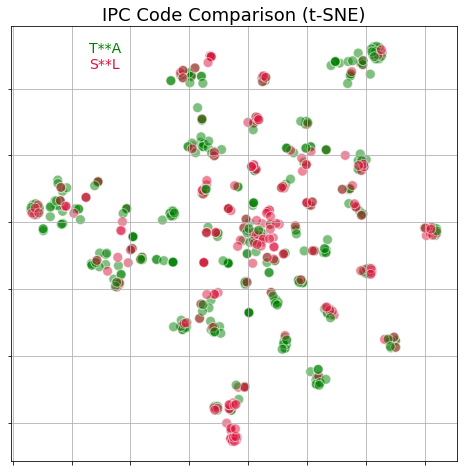

In [21]:
color1 = 'green'
color2 = 'crimson'
tsne_df = pd.DataFrame(tsne, columns=['x', 'y'])
colors = np.where(df['company'] == 'TATA', color1, color2)
ax = tsne_df.plot.scatter(x='x', y='y', figsize=(8, 8), grid=True, 
   alpha=0.5, color=colors, edgecolors='white', s=96)
ax.set_xlabel('')
ax.set_ylabel('')
ax.text(-27, 25.5, 'T**A', color=color1, fontsize=14)
ax.text(-27, 23, 'S**L', color=color2, fontsize=14)
ax.set_title('IPC Code Comparison (t-SNE)', fontsize=18)
ax.set_xticklabels(['' for i in range(6)])
ax.set_yticklabels(['' for i in range(7)])
plt.savefig('ipc-scatter-tsne.png')
None

### Use UMAP to Obtain 2-D (X, Y) Mapping

In [15]:
import umap

umap2d = umap.UMAP().fit_transform(tf)

print('Rows: %d, Features: %d' % umap2d.shape)

Rows: 588, Features: 2


In [16]:
umap2d[:10, :]

array([[ 11.63986111,  -0.42738858],
       [ 13.19987774,  -0.66033715],
       [  8.9006176 ,   4.09714746],
       [  2.84797406,   1.70994651],
       [ 10.35317135,  -0.41757518],
       [  4.14213276,   0.91088641],
       [ -1.55171263,  -2.40802693],
       [ -1.98058283,  -2.71996164],
       [ 10.34498215,  -9.02437115],
       [ -5.12866735,   5.75599384]], dtype=float32)

### Scatter Plot of 2-D Data

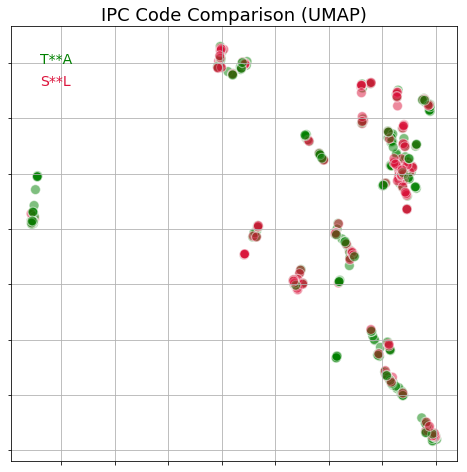

In [22]:
color1 = 'green'
color2 = 'crimson'
umap_df = pd.DataFrame(umap2d, columns=['x', 'y'])
colors = np.where(df['company'] == 'TATA', color1, color2)
ax = umap_df.plot.scatter(x='x', y='y', figsize=(8, 8), grid=True, 
   alpha=0.5, color=colors, edgecolors='white', s=96)
ax.set_xlabel('')
ax.set_ylabel('')
ax.text(-22, 5, 'T**A', color=color1, fontsize=14)
ax.text(-22, 4, 'S**L', color=color2, fontsize=14)
ax.set_title('IPC Code Comparison (UMAP)', fontsize=18)
ax.set_xticklabels(['' for i in range(6)])
ax.set_yticklabels(['' for i in range(7)])
plt.savefig('ipc-scatter-umap.png')
None